# initialisation

In [1]:
import backproject
import numpy as np
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import glob
import cv2
import torch
from sklearn.cluster import KMeans
import os

In [2]:
path_to_traj = "/home/koerner/Project_Dogu/wsnsl/Datasets/Replica/room1/traj.txt"
T_wc = np.loadtxt(path_to_traj).reshape(-1, 4, 4)
T_wc[:, 1:3] *= -1
color_paths = sorted(glob.glob("/home/koerner/Project_Dogu/wsnsl/Datasets/Replica/room1/results/frame*.jpg"))
print(color_paths)
depth_paths = sorted(glob.glob(f"/home/koerner/Project_Dogu/wsnsl/Datasets/Replica/room1/results/depth*.png"))
print(depth_paths)

['/home/koerner/Project_Dogu/wsnsl/Datasets/Replica/room1/results/frame000000.jpg', '/home/koerner/Project_Dogu/wsnsl/Datasets/Replica/room1/results/frame000001.jpg', '/home/koerner/Project_Dogu/wsnsl/Datasets/Replica/room1/results/frame000002.jpg', '/home/koerner/Project_Dogu/wsnsl/Datasets/Replica/room1/results/frame000003.jpg', '/home/koerner/Project_Dogu/wsnsl/Datasets/Replica/room1/results/frame000004.jpg', '/home/koerner/Project_Dogu/wsnsl/Datasets/Replica/room1/results/frame000005.jpg', '/home/koerner/Project_Dogu/wsnsl/Datasets/Replica/room1/results/frame000006.jpg', '/home/koerner/Project_Dogu/wsnsl/Datasets/Replica/room1/results/frame000007.jpg', '/home/koerner/Project_Dogu/wsnsl/Datasets/Replica/room1/results/frame000008.jpg', '/home/koerner/Project_Dogu/wsnsl/Datasets/Replica/room1/results/frame000009.jpg', '/home/koerner/Project_Dogu/wsnsl/Datasets/Replica/room1/results/frame000010.jpg', '/home/koerner/Project_Dogu/wsnsl/Datasets/Replica/room1/results/frame000011.jpg', '/h

In [3]:
'''
for i in range(20):
    color_path = color_paths[i*50]
    color_data = cv2.imread(color_path)
    image = cv2.cvtColor(color_data, cv2.COLOR_BGR2RGB)
    masks = mask_generator.generate(image)
    images.append(image)
    masksarr.append(masks)
del sam
'''


'\nfor i in range(20):\n    color_path = color_paths[i*50]\n    color_data = cv2.imread(color_path)\n    image = cv2.cvtColor(color_data, cv2.COLOR_BGR2RGB)\n    masks = mask_generator.generate(image)\n    images.append(image)\n    masksarr.append(masks)\ndel sam\n'

In [4]:
import vis
import matplotlib.pyplot as plt
'''
for i in range(20):
    plt.figure(figsize=(20,20))
    plt.imshow(images[i])
    vis.show_anns(masksarr[i])
    plt.axis('off')
    plt.show() 
    '''
def visualizerForAuto(image, masks):
    plt.figure(figsize=(20,20))
    plt.imshow(image)
    vis.show_anns(masks)
    plt.axis('off')
    plt.show() 
def visualizerWithPrompts(image,masks,prompts):
    plt.figure(figsize=(20,20))
    plt.imshow(image)
    vis.show_anns(masks)
    plt.scatter(prompts[0,:],prompts[1,:],c='r',s=10)
    plt.axis('off')
    plt.show()

In [5]:
images=[]
masksarr=[]

K = np.eye(3)
K[0, 0] = 600.0
K[1, 1] = 600.0
K[0, 2] = 599.5
K[1, 2] = 339.5

# Helper

In [6]:

def readDepth(filepath):
    depth = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)
    depth_data = depth.astype(np.float32) / 6553.5
    depth_data = torch.from_numpy(depth_data)
    return depth_data


def checkIfInsideImage(backprojectedSamples, zg, Depthg, border):
    backprojectedSamples = backprojectedSamples.astype(int)
    # efficient
    # filter out samples outside of image bounds
    condition = (
        (backprojectedSamples[1, :] < 0 + border)
        | (backprojectedSamples[0, :] < 0 + border)
        | (backprojectedSamples[1, :] > 679 - border)
        | (backprojectedSamples[0, :] > 1199 - border)
    )
    filteredIndices = np.where(condition)
    filteredBackProj = backprojectedSamples[:, ~condition]

    depthg = np.array(Depthg[filteredBackProj[1, :], filteredBackProj[0, :]])
    zg = np.delete(zg, filteredIndices)
    depthCheck = depthg - zg
    # print(f'depthCkeck, smaller 0.005: {np.count_nonzero(abs(depthCheck) < 0.005)}, depthCheck, smaller 0.01: {np.count_nonzero(abs(depthCheck) < 0.01)}, smaller 0.1: {np.count_nonzero(abs(depthCheck) < 0.1)}')
    indices = np.where(abs(depthCheck) < 0.01)
    filteredBackProj = filteredBackProj[:, indices]
    return filteredBackProj

def generateIds(masks, min_area=1000):
    """sortedMasks = sorted(masks, key=(lambda x: x["area"]), reverse=True)
    ids = np.ones(
        (
            sortedMasks[0]["segmentation"].shape[0],
            sortedMasks[0]["segmentation"].shape[1],
            1,
        )
    )
    # maybe more efficient
    # first frame has 85 instances so not too bad
    for i, ann in enumerate(sortedMasks):
        m = ann["segmentation"]
        idsForEachMask = np.concatenate([[i]])
        ids[m] = idsForEachMask
    return ids.squeeze().astype(np.int32)"""
    sortedMasks = sorted(masks, key=(lambda x: x["area"]), reverse=True)
    if min_area > 0:
        sortedMasks = [mask for mask in sortedMasks if mask["area"] > min_area]
    ids = np.full(
            (sortedMasks[0]["segmentation"].shape[0],
            sortedMasks[0]["segmentation"].shape[1]),
            -100,
        )
    for i, ann in enumerate(sortedMasks):
        m = ann["segmentation"]
        ids[m] = i
    unique_ids,counts = np.unique(ids, return_counts=True)
    for i in range(len(unique_ids)):
        if counts[i] < min_area:
            ids[ids == unique_ids[i]] = -100
    return ids

def sample_from_instances_with_ids_area(ids, numberOfMasks, points_per_instance=1):
    tensors = []

    temp=np.unique(ids)[1:]
    for i,element in enumerate(list(temp.astype(int))):
        if element >=0:            
            labels = np.where(ids == element)
            indices = list(zip(labels[0], labels[1]))
            points_per_instance= np.sum(ids == element)
            points_per_instance=int(2*np.log2(points_per_instance))
            if len(indices) > points_per_instance:  # Check if there are any True pixels
                sampled_indices = np.linspace(0, len(indices)-1, points_per_instance, dtype=int)
                sampled_tensor = torch.tensor([indices[j][::-1] for j in sampled_indices]).T
                element_tensor = torch.full((sampled_tensor.shape[1],), element)
                
                element_tensor = element_tensor.unsqueeze(0)
                
                tensors.append(torch.cat((sampled_tensor, element_tensor), axis=0))

    torch_sampled_indices = torch.cat(tensors, axis=1)
    return torch_sampled_indices.to(torch.int32)

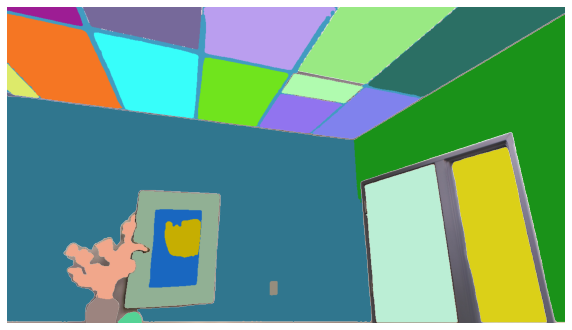

In [7]:
sam_checkpoint = '/home/koerner/Project/nice-slam/sam/sam_vit_h_4b8939.pth'
model_type = "vit_h"


sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device="cuda")


mask_generator = SamAutomaticMaskGenerator(
    sam, points_per_side=16, pred_iou_thresh=0.9, stability_score_thresh=0.9, crop_nms_thresh=0.2,box_nms_thresh=0.4,crop_n_layers=0, crop_n_points_downscale_factor=2, min_mask_region_area=10000)
#crop_n_layers (int): If >0, mask prediction will be run again on
#crops of the image. Sets the number of layers to run, where each
 #layer has 2**i_layer number of image crops.
 #crop_nms_thresh (float): The box IoU cutoff used by non-maximal suppression to filter duplicate masks between different crops.
"""
        Using a SAM model, generates masks for the entire image.
        Generates a grid of point prompts over the image, then filters
        low quality and duplicate masks. The default settings are chosen
        for SAM with a ViT-H backbone.

        Arguments:
          model (Sam): The SAM model to use for mask prediction.
          points_per_side (int or None): The number of points to be sampled
            along one side of the image. The total number of points is
            points_per_side**2. If None, 'point_grids' must provide explicit
            point sampling.
          points_per_batch (int): Sets the number of points run simultaneously
            by the model. Higher numbers may be faster but use more GPU memory.
          pred_iou_thresh (float): A filtering threshold in [0,1], using the
            model's predicted mask quality.
          stability_score_thresh (float): A filtering threshold in [0,1], using
            the stability of the mask under changes to the cutoff used to binarize
            the model's mask predictions.
          stability_score_offset (float): The amount to shift the cutoff when
            calculated the stability score.
          box_nms_thresh (float): The box IoU cutoff used by non-maximal
            suppression to filter duplicate masks.
          crop_n_layers (int): If >0, mask prediction will be run again on
            crops of the image. Sets the number of layers to run, where each
            layer has 2**i_layer number of image crops.
          crop_nms_thresh (float): The box IoU cutoff used by non-maximal
            suppression to filter duplicate masks between different crops.
          crop_overlap_ratio (float): Sets the degree to which crops overlap.
            In the first crop layer, crops will overlap by this fraction of
            the image length. Later layers with more crops scale down this overlap.
          crop_n_points_downscale_factor (int): The number of points-per-side
            sampled in layer n is scaled down by crop_n_points_downscale_factor**n.
          point_grids (list(np.ndarray) or None): A list over explicit grids
            of points used for sampling, normalized to [0,1]. The nth grid in the
            list is used in the nth crop layer. Exclusive with points_per_side.
          min_mask_region_area (int): If >0, postprocessing will be applied
            to remove disconnected regions and holes in masks with area smaller
            than min_mask_region_area. Requires opencv.
          output_mode (str): The form masks are returned in. Can be 'binary_mask',
            'uncompressed_rle', or 'coco_rle'. 'coco_rle' requires pycocotools.
            For large resolutions, 'binary_mask' may consume large amounts of
            memory.
        """
currFramenumber=0
color_data = cv2.imread(color_paths[currFramenumber])
image = cv2.cvtColor(color_data, cv2.COLOR_BGR2RGB)
masks = mask_generator.generate(image)
ids = generateIds(masks, min_area=1000)
#idler sortlancak
plt.figure(figsize=(10,10))
plt.imshow(image)
vis.show_anns(masks)
plt.axis('off')
plt.show()

# Code

In [8]:

def createFrontMappingAutosort(
    curr_frame_number,
    T,
    K,
    depths,
    automaticMask,
    max_id=None,
    update=None,
    points_per_instance=5,
    current_frame=None,
    samples=None,
    smallesMaskSize=10000,
    kernel_size=80,
    num_of_clusters=4,
    deleted=None,
    border=25,
    overlap_threshold=0.5,
    relevant_threshhold=0.6,
    every_frame=15,
    merging_parameter=10,
    hit_percent=0.1,
    verbose=False,
):
    visualizerForId=vis.visualizerForIds()
    
    if curr_frame_number==0:
        masks = automaticMask.generate(current_frame)
        ids = generateIds(masks, min_area=smallesMaskSize)
        #idler sortlancak
        if verbose:
            plt.figure(figsize=(10,10))
            plt.imshow(current_frame)
            vis.show_anns(masks)
            plt.axis('off')
            plt.savefig(os.path.join("/home/koerner/Project_Dogu/wsnsl/output/Own/room0/segmentation", f'{curr_frame_number}_{0}_mask_{curr_frame_number}_{-1}.png'))
            plt.show()
        max_id = ids.max()+1
        samplesFromCurrent = sample_from_instances_with_ids_area(
            ids, max_id, points_per_instance=1000
        )
        realWorldSamples = backproject.realWorldProject(
            samplesFromCurrent[:2, :],
            T_wc[0],
            K,
            readDepth(depth_paths[0]),
        )
        realWorldSamples = np.concatenate(
            (realWorldSamples, samplesFromCurrent[2:, :]), axis=0
        )
        print("First iter unique",len(np.unique(ids)))
        visualizerForId.visualizer(anns=ids, path = os.path.join("/home/koerner/Project_Dogu/wsnsl/output/Own/room1/segmentation", f'{curr_frame_number}_initial.png'))

        return ids, realWorldSamples, max_id

    T_current = T[curr_frame_number]
    depthf = readDepth(depths[curr_frame_number])
    
    frontProjectedSamples, projDepth = backproject.camProject(samples, T_current, K)
    frontProjectedSamples = checkIfInsideImage(
        frontProjectedSamples, projDepth, depthf, border=border
    )
    if frontProjectedSamples.ndim == 3:
        frontProjectedSamples = frontProjectedSamples.reshape(3, -1)

    mask = mask_generator.generate(current_frame)
    # TODO suna bakilcak
    ids = generateIds(mask, min_area=smallesMaskSize)
    current_unique_ids=np.unique(ids)
    
    
    """ 
    # Projected everything onto the current frame
    # Now for each sample project on to the image and check if it is inside the each mask instance
    # on to the each currentMask take majority of the samples and assign to the mask
    # some are pruned do not take the max_id into account
    """
    copyOfIds = np.full(ids.shape, -100)
    for currentMaskId in current_unique_ids:
        if currentMaskId < 0:
            continue
        currentMask= ids == currentMaskId
        dictOfIds = {-100: -100}
        for instance in np.unique(frontProjectedSamples[2, :]):
            if instance >= 0:
                samplesInside= frontProjectedSamples[:, frontProjectedSamples[2, :] == instance]
                insideTheMask= currentMask[samplesInside[1, :] , samplesInside[0, :]]
                dictOfIds[instance] = np.sum(insideTheMask)
        maxForMask= max(dictOfIds, key=dictOfIds.get)
        if maxForMask != -100 and dictOfIds[maxForMask] > 0.4 * np.sum(insideTheMask):
            copyOfIds[ids==currentMaskId ] = maxForMask
        elif maxForMask != -100:
            copyOfIds[ ids==currentMaskId ] = max_id
            max_id += 1
            print("CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT SEEEEEEEEEEEEEEEN")
        print("The Found Projection instance",maxForMask)
        print("Mapping",dictOfIds)
        print("MaxId",max_id)
        if verbose:
            visualizerForId.visualizer(anns=copyOfIds, path = os.path.join("/home/koerner/Project_Dogu/wsnsl/output/Own/room1/segmentation", f'{curr_frame_number}_{currentMaskId}_mask{maxForMask}.png'))
    ids=copyOfIds
    if True:
        visualizerForId.visualizer(anns=ids, path = os.path.join("/home/koerner/Project_Dogu/wsnsl/output/Own/room1/segmentation", f'_final_{curr_frame_number}.png'))
    if border != 0:
        ids[0 : 2 * border] = -100
        ids[-2 * border :] = -100
        ids[:, 0 : 2 * border] = -100
        ids[:, -2 * border :] = -100
    
    numberOfMasks = len(np.unique(ids))

    # TODO sample according to the areas of the masks
    samplesFromCurrent = sample_from_instances_with_ids_area(
        ids, numberOfMasks, points_per_instance=100
    )
    # 3d
    realWorldProjectCurr = backproject.realWorldProject(
        samplesFromCurrent[:2, :], T[curr_frame_number], K, depthf
    )
    # add the ids
    realWorldProjectCurr = np.concatenate(
        (realWorldProjectCurr, samplesFromCurrent[2:, :]), axis=0
    )
    samples = np.concatenate((samples, realWorldProjectCurr), axis=1)
    #max_id = np.max(samples[2:, :])
    #print(samples)
    print("Current unique ids", current_unique_ids)

    return ids, samples, max_id


'''
            visualizerForId.visualizer(anns=ids, path = os.path.join("/home/koerner/Project_Dogu/wsnsl/output/Own/room0/segmentation", f'{curr_frame_number}_{currentMaskId}_mask_{curr_frame_number}_{most_common_instance}.png'), prompts = frontProjectedSamples[:2, filter_most_common])
            '''      

First iter unique 23


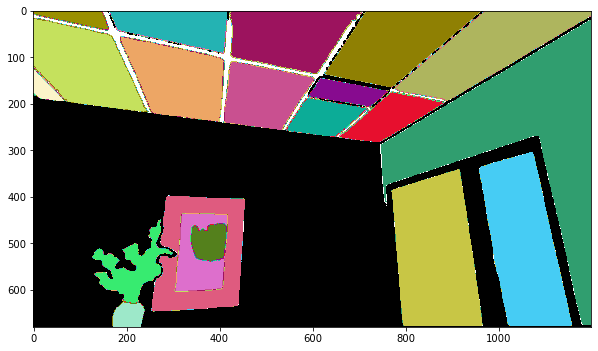

The Found Projection instance 0
Mapping {-100: -100, 0: 34, 5: 0, 8: 0, 12: 0, 14: 0, 18: 0, 20: 0, 21: 0}
MaxId 22
CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT SEEEEEEEEEEEEEEEN
The Found Projection instance 0
Mapping {-100: -100, 0: 0, 5: 0, 8: 0, 12: 0, 14: 0, 18: 0, 20: 0, 21: 0}
MaxId 23
CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT SEEEEEEEEEEEEEEEN
The Found Projection instance 0
Mapping {-100: -100, 0: 0, 5: 0, 8: 0, 12: 0, 14: 0, 18: 0, 20: 0, 21: 0}
MaxId 24
CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT SEEEEEEEEEEEEEEEN
The Found Projection instance 0
Mapping {-100: -100, 0: 0, 5: 0, 8: 0, 12: 0, 14: 0, 18: 0, 20: 0, 21: 0}
MaxId 25
CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT SEEEEEEEEEEEEEEEN
The Found Projection instance 0
Mapping {-100: -100, 0: 0, 5: 0, 8: 0, 12: 0, 14: 0, 18: 0, 20: 0, 21: 0}
MaxId 26
The Found Projection instance 5
Mapping {-100: -100, 0: 0, 5: 27, 8: 0, 12: 2, 14: 0, 18: 0, 20: 0, 21: 0}
MaxId 26
CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT S

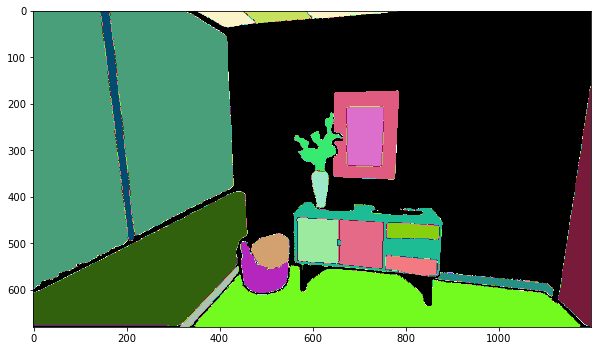

Current unique ids [-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17   18   19   20]
The Found Projection instance 22
Mapping {-100: -100, 0: 0, 1: 0, 5: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 16, 23: 0, 25: 0, 28: 9}
MaxId 36
The Found Projection instance 0
Mapping {-100: -100, 0: 51, 1: 0, 5: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 25: 0, 28: 0}
MaxId 36
The Found Projection instance 19
Mapping {-100: -100, 0: 0, 1: 11, 5: 0, 7: 0, 8: 1, 9: 0, 10: 0, 11: 1, 12: 0, 13: 0, 14: 0, 16: 0, 17: 0, 18: 0, 19: 24, 20: 0, 21: 11, 22: 0, 23: 0, 25: 0, 28: 0}
MaxId 36
The Found Projection instance 22
Mapping {-100: -100, 0: 0, 1: 0, 5: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 14, 23: 0, 25: 0, 28: 0}
MaxId 36
The Found Projection instance 13
Mapping {-100:

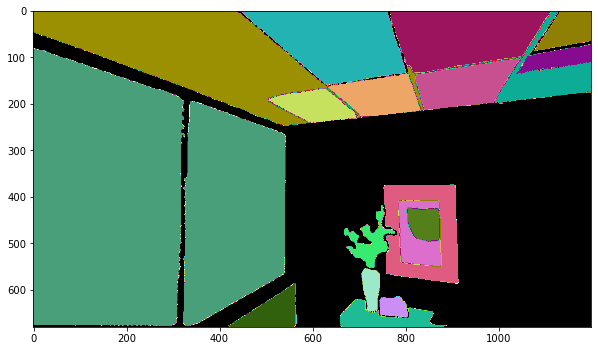

Current unique ids [-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17   18   19   20]
The Found Projection instance 24
Mapping {-100: -100, 0: 0, 5: 0, 12: 0, 14: 0, 18: 0, 20: 0, 22: 0, 23: 0, 24: 23, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0}
MaxId 37
The Found Projection instance 0
Mapping {-100: -100, 0: 30, 5: 0, 12: 0, 14: 0, 18: 0, 20: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0}
MaxId 37
The Found Projection instance 22
Mapping {-100: -100, 0: 0, 5: 0, 12: 0, 14: 0, 18: 0, 20: 0, 22: 21, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0}
MaxId 37
The Found Projection instance 23
Mapping {-100: -100, 0: 0, 5: 0, 12: 0, 14: 0, 18: 0, 20: 0, 22: 0, 23: 51, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 2, 36: 0}
MaxId 37
The Found Projection instance 0
M

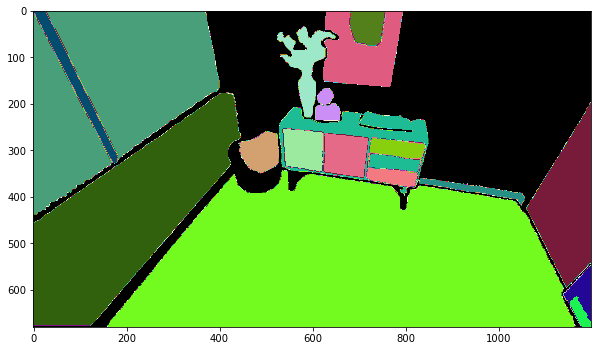

Current unique ids [-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17   18   19   20   21   22]
The Found Projection instance 24
Mapping {-100: -100, 0: 0, 20: 0, 22: 0, 23: 0, 24: 36, 25: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 35: 0}
MaxId 39
The Found Projection instance 23
Mapping {-100: -100, 0: 0, 20: 0, 22: 0, 23: 64, 24: 0, 25: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 35: 1}
MaxId 39
CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT SEEEEEEEEEEEEEEEN
The Found Projection instance 0
Mapping {-100: -100, 0: 0, 20: 0, 22: 0, 23: 0, 24: 0, 25: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 35: 0}
MaxId 40
The Found Projection instance 22
Mapping {-100: -100, 0: 0, 20: 0, 22: 4, 23: 0, 24: 0, 25: 0, 27: 0, 28: 2, 29: 0, 30: 0, 31: 0, 35: 0}
MaxId 40
CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT SEEEEEEEEEEEEEEEN
The Found Projection instance 0
Mapping {-100: -100, 0: 0, 20: 0, 22: 0, 23: 0, 24: 0, 25: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 35: 0}
MaxId 4

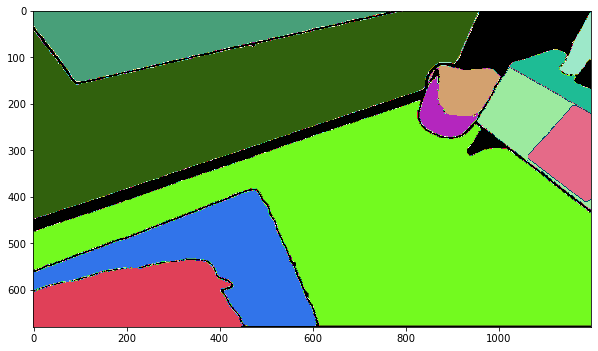

Current unique ids [-100    0    1    2    3    4    5    6    7    8    9   10   11]
The Found Projection instance 40
Mapping {-100: -100, 23: 0, 24: 0, 39: 0, 40: 23}
MaxId 41
The Found Projection instance 24
Mapping {-100: -100, 23: 0, 24: 10, 39: 0, 40: 0}
MaxId 41
The Found Projection instance 23
Mapping {-100: -100, 23: 3, 24: 0, 39: 0, 40: 0}
MaxId 41
CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT SEEEEEEEEEEEEEEEN
The Found Projection instance 23
Mapping {-100: -100, 23: 0, 24: 0, 39: 0, 40: 0}
MaxId 42
CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT SEEEEEEEEEEEEEEEN
The Found Projection instance 23
Mapping {-100: -100, 23: 0, 24: 0, 39: 0, 40: 0}
MaxId 43
CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT SEEEEEEEEEEEEEEEN
The Found Projection instance 23
Mapping {-100: -100, 23: 0, 24: 0, 39: 0, 40: 0}
MaxId 44


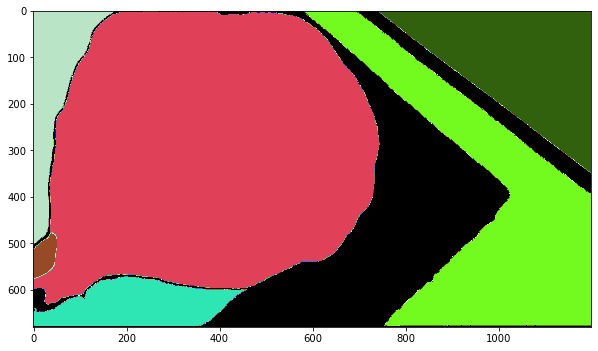

Current unique ids [-100    0    1    2    3    4    5]
The Found Projection instance 23
Mapping {-100: -100, 22: 0, 23: 5}
MaxId 44
The Found Projection instance 22
Mapping {-100: -100, 22: 21, 23: 0}
MaxId 44
CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT SEEEEEEEEEEEEEEEN
The Found Projection instance 22
Mapping {-100: -100, 22: 0, 23: 0}
MaxId 45
CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT SEEEEEEEEEEEEEEEN
The Found Projection instance 22
Mapping {-100: -100, 22: 0, 23: 0}
MaxId 46
CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT SEEEEEEEEEEEEEEEN
The Found Projection instance 22
Mapping {-100: -100, 22: 0, 23: 0}
MaxId 47
CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT SEEEEEEEEEEEEEEEN
The Found Projection instance 22
Mapping {-100: -100, 22: 0, 23: 0}
MaxId 48
CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT SEEEEEEEEEEEEEEEN
The Found Projection instance 22
Mapping {-100: -100, 22: 0, 23: 0}
MaxId 49
CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT SEEEEEEEEEEEEEEEN
The Found Proj

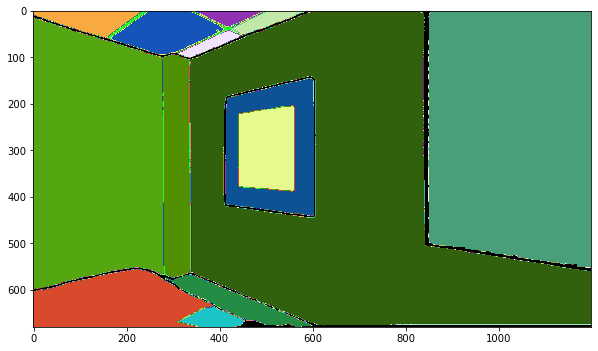

Current unique ids [-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15]
The Found Projection instance 23
Mapping {-100: -100, 22: 0, 23: 64, 24: 0, 39: 0, 40: 0, 42: 0, 44: 0, 45: 0, 46: 0, 48: 1, 49: 0, 51: 0}
MaxId 57
The Found Projection instance 40
Mapping {-100: -100, 22: 0, 23: 0, 24: 0, 39: 0, 40: 44, 42: 0, 44: 0, 45: 0, 46: 0, 48: 0, 49: 0, 51: 0}
MaxId 57
The Found Projection instance 44
Mapping {-100: -100, 22: 0, 23: 0, 24: 0, 39: 0, 40: 0, 42: 0, 44: 22, 45: 0, 46: 0, 48: 0, 49: 0, 51: 0}
MaxId 57
The Found Projection instance 22
Mapping {-100: -100, 22: 31, 23: 0, 24: 0, 39: 0, 40: 0, 42: 0, 44: 0, 45: 0, 46: 0, 48: 0, 49: 0, 51: 0}
MaxId 57
CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT SEEEEEEEEEEEEEEEN
The Found Projection instance 22
Mapping {-100: -100, 22: 0, 23: 0, 24: 0, 39: 0, 40: 0, 42: 0, 44: 0, 45: 0, 46: 0, 48: 0, 49: 0, 51: 0}
MaxId 58
The Found Projection instance 49
Mapping {-100: -100, 22: 0, 23: 0, 24: 0, 39: 0, 40: 0, 

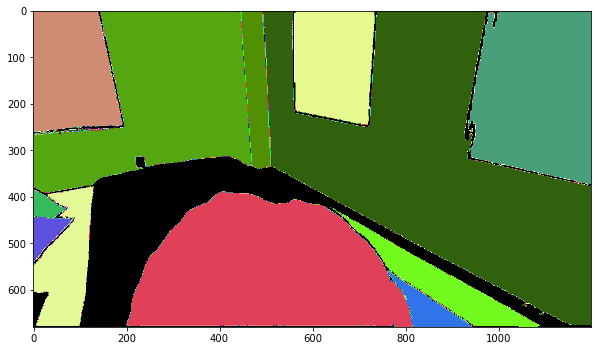

Current unique ids [-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14]
The Found Projection instance 23
Mapping {-100: -100, 23: 56, 24: 0, 40: 0, 42: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0}
MaxId 61
The Found Projection instance 44
Mapping {-100: -100, 23: 0, 24: 0, 40: 0, 42: 0, 44: 66, 45: 0, 46: 0, 47: 0, 48: 2, 49: 0, 50: 0, 51: 0, 52: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0}
MaxId 61
The Found Projection instance 57
Mapping {-100: -100, 23: 0, 24: 0, 40: 0, 42: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 56: 0, 57: 27, 58: 0, 59: 0, 60: 0}
MaxId 61
The Found Projection instance 40
Mapping {-100: -100, 23: 0, 24: 0, 40: 31, 42: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0}
MaxId 61
CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT SEEEEEEEEEEEEEEEN
The Found Projection instance 23
Mapping {-100: -100, 23: 0, 24: 0, 40: 0

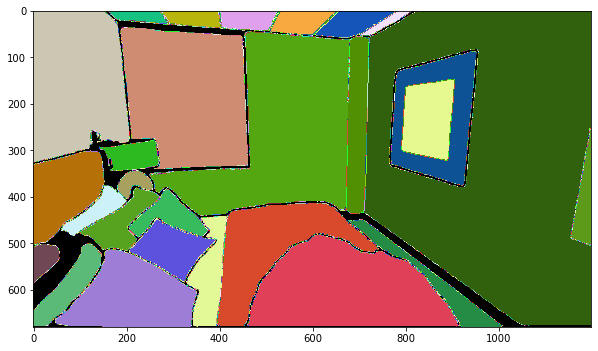

Current unique ids [-100    0    1    2    3    4    5    6    7    8    9   11   12   13
   14   15   16   17   18   19   20   21   22   23   24   25   26   27
   28   29   30   31]
The Found Projection instance 61
Mapping {-100: -100, 23: 0, 40: 0, 42: 0, 44: 1, 46: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 25, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 68: 0, 71: 0, 73: 0}
MaxId 74
The Found Projection instance 44
Mapping {-100: -100, 23: 0, 40: 0, 42: 0, 44: 63, 46: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 68: 0, 71: 0, 73: 0}
MaxId 74
CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT SEEEEEEEEEEEEEEEN
The Found Projection instance 23
Mapping {-100: -100, 23: 0, 40: 0, 42: 0, 44: 0, 46: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 68: 0, 71: 0, 73: 0}
MaxId 75
The Found Projection instance 57
Mapping {-100: -100, 23: 0, 40: 0, 42: 0, 44: 0, 46: 0, 57: 57, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 68: 0, 71: 0, 73: 0}
Ma

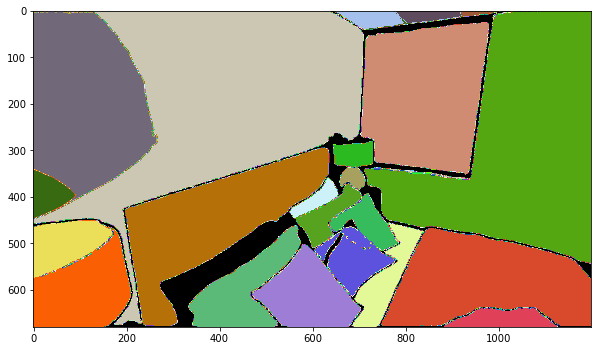

Current unique ids [-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17   18   19   20   21   23   24]
The Found Projection instance 61
Mapping {-100: -100, 2: 5, 44: 0, 57: 0, 60: 0, 61: 61, 63: 0, 65: 0, 66: 0, 68: 0, 73: 0, 74: 31, 75: 0, 76: 0, 78: 1}
MaxId 81
CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT SEEEEEEEEEEEEEEEN
The Found Projection instance 2
Mapping {-100: -100, 2: 0, 44: 0, 57: 0, 60: 0, 61: 0, 63: 0, 65: 0, 66: 0, 68: 0, 73: 0, 74: 0, 75: 0, 76: 0, 78: 0}
MaxId 82
The Found Projection instance 57
Mapping {-100: -100, 2: 0, 44: 0, 57: 56, 60: 0, 61: 0, 63: 0, 65: 0, 66: 0, 68: 0, 73: 0, 74: 0, 75: 0, 76: 0, 78: 0}
MaxId 82
The Found Projection instance 63
Mapping {-100: -100, 2: 0, 44: 0, 57: 0, 60: 0, 61: 0, 63: 46, 65: 0, 66: 0, 68: 1, 73: 0, 74: 0, 75: 0, 76: 0, 78: 0}
MaxId 82
CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT SEEEEEEEEEEEEEEEN
The Found Projection instance 2
Mapping {-100: -100, 2: 0, 44: 0, 57: 0, 60: 0, 

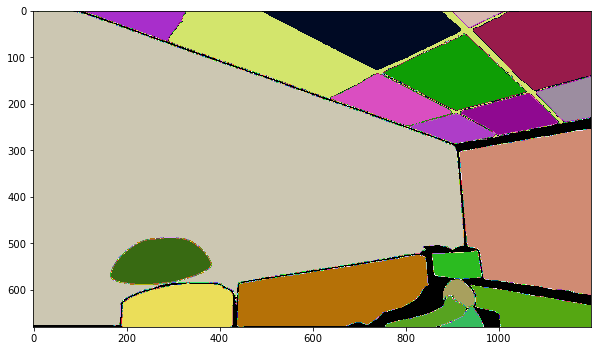

Current unique ids [-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17   18   19]
The Found Projection instance 61
Mapping {-100: -100, 2: 3, 4: 0, 40: 0, 42: 0, 44: 0, 46: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 71, 62: 0, 63: 1, 64: 0, 65: 0, 66: 0, 68: 0, 71: 0, 73: 0, 74: 0, 75: 0, 76: 0, 78: 0}
MaxId 91
The Found Projection instance 74
Mapping {-100: -100, 2: 4, 4: 0, 40: 0, 42: 0, 44: 0, 46: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 16, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 68: 0, 71: 0, 73: 0, 74: 31, 75: 0, 76: 0, 78: 0}
MaxId 91
The Found Projection instance 57
Mapping {-100: -100, 2: 0, 4: 0, 40: 0, 42: 0, 44: 0, 46: 0, 57: 69, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 68: 0, 71: 0, 73: 0, 74: 0, 75: 0, 76: 0, 78: 0}
MaxId 91
The Found Projection instance 46
Mapping {-100: -100, 2: 0, 4: 0, 40: 1, 42: 25, 44: 0, 46: 38, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 68: 0, 71: 0, 73: 0, 74: 0, 75: 0, 76

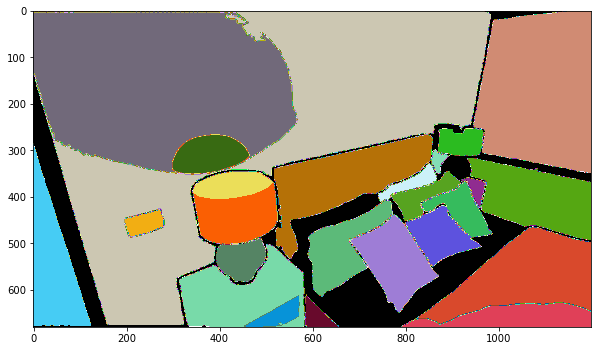

Current unique ids [-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17   18   19   20   21   22   23   24   25]
The Found Projection instance 61
Mapping {-100: -100, 23: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 46: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 99, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 68: 0, 71: 0, 73: 0, 74: 2, 75: 0, 76: 0, 78: 0, 91: 0, 92: 0, 93: 0, 94: 2, 95: 0, 96: 0, 97: 0}
MaxId 98
The Found Projection instance 44
Mapping {-100: -100, 23: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 156, 46: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 68: 0, 71: 0, 73: 0, 74: 0, 75: 0, 76: 0, 78: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 1, 97: 0}
MaxId 98
The Found Projection instance 74
Mapping {-100: -100, 23: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 46: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 11, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 68: 0, 71: 0, 73: 0, 74: 50, 75: 0, 76: 0, 78: 3, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0}
MaxId 9

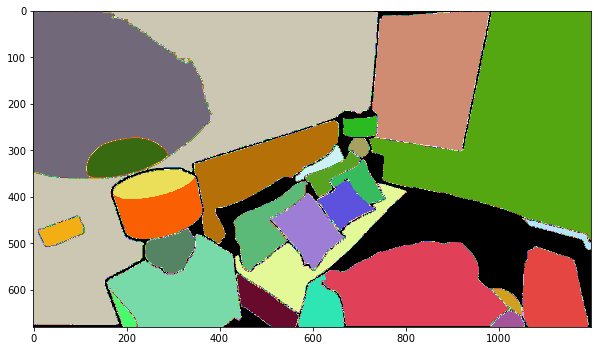

Current unique ids [-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17   18   19   20   21   22   23   24   25   26
   27   28]
The Found Projection instance 61
Mapping {-100: -100, 23: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 2, 46: 0, 47: 0, 48: 0, 50: 0, 51: 0, 52: 0, 57: 1, 58: 0, 59: 0, 60: 0, 61: 135, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 68: 0, 71: 0, 73: 0, 74: 86, 75: 0, 76: 0, 78: 1, 81: 0, 83: 0, 84: 0, 85: 0, 86: 0, 88: 0, 89: 0, 91: 0, 92: 0, 93: 0, 94: 6, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 101: 0}
MaxId 103
The Found Projection instance 44
Mapping {-100: -100, 23: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 204, 46: 0, 47: 0, 48: 0, 50: 0, 51: 0, 52: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 68: 0, 71: 0, 73: 0, 74: 0, 75: 0, 76: 0, 78: 0, 81: 0, 83: 0, 84: 0, 85: 0, 86: 0, 88: 0, 89: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 101: 0}
MaxId 103
The Found Projection instance 86
Mapping {-100: 

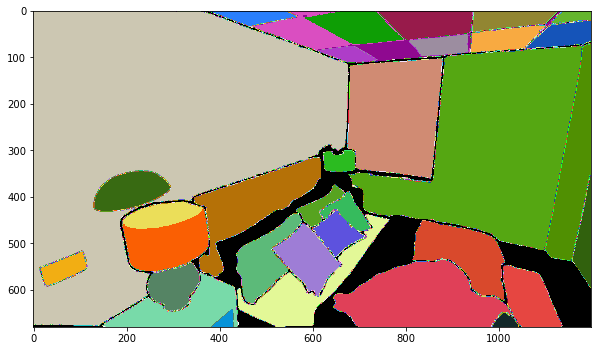

Current unique ids [-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17   18   19   20   21   22   23   24   25   26
   27   28   29   30   31   32   33   34   35   36   37]
The Found Projection instance 61
Mapping {-100: -100, 23: 0, 44: 2, 46: 0, 47: 0, 48: 0, 50: 0, 52: 0, 56: 0, 57: 1, 58: 0, 59: 0, 60: 0, 61: 129, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 68: 0, 71: 0, 73: 0, 74: 69, 75: 0, 76: 0, 78: 7, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 88: 0, 89: 0, 96: 0, 97: 0, 99: 0}
MaxId 107
The Found Projection instance 44
Mapping {-100: -100, 23: 7, 44: 229, 46: 0, 47: 0, 48: 3, 50: 0, 52: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 68: 0, 71: 0, 73: 0, 74: 0, 75: 0, 76: 0, 78: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 88: 0, 89: 0, 96: 0, 97: 0, 99: 0}
MaxId 107
The Found Projection instance 56
Mapping {-100: -100, 23: 0, 44: 0, 46: 0, 47: 7, 48: 1, 50: 1, 52: 1, 56: 16, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0,

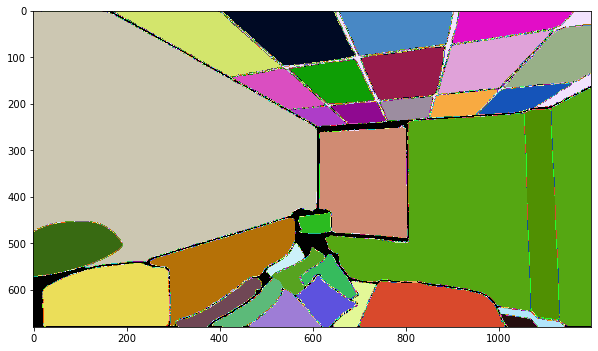

Current unique ids [-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17   18   19   20   21   22   23   24   25   26
   27   28   29   30   31   32   33]
The Found Projection instance 61
Mapping {-100: -100, 23: 0, 44: 0, 46: 0, 47: 0, 50: 0, 52: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 175, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 68: 0, 71: 0, 73: 0, 74: 86, 75: 0, 76: 0, 78: 3, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 88: 0, 89: 0, 97: 0, 107: 0, 108: 0}
MaxId 112
The Found Projection instance 56
Mapping {-100: -100, 23: 0, 44: 0, 46: 0, 47: 3, 50: 8, 52: 1, 56: 15, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 68: 0, 71: 0, 73: 0, 74: 0, 75: 0, 76: 0, 78: 0, 81: 9, 82: 0, 83: 3, 84: 6, 85: 4, 86: 7, 88: 3, 89: 3, 97: 0, 107: 0, 108: 0}
MaxId 112
The Found Projection instance 44
Mapping {-100: -100, 23: 0, 44: 197, 46: 0, 47: 0, 50: 0, 52: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 6

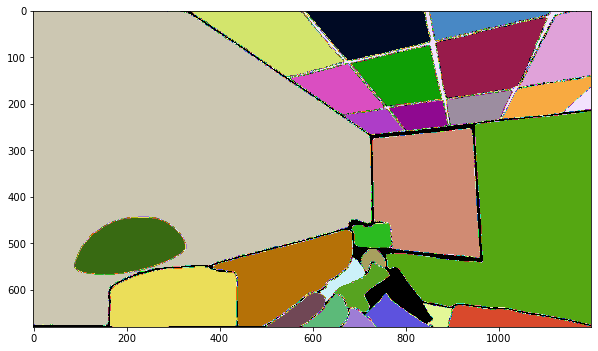

Current unique ids [-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17   18   19   20   21   22   23   24   25   26
   27]
The Found Projection instance 44
Mapping {-100: -100, 23: 2, 40: 0, 42: 0, 44: 3, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 54: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 1, 62: 0, 63: 1, 64: 0, 65: 0, 66: 0, 68: 0, 71: 0, 73: 0, 74: 0, 75: 0, 76: 0, 78: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 88: 0, 89: 0, 92: 0, 97: 0, 107: 0, 108: 0, 109: 0, 110: 0}
MaxId 112
The Found Projection instance 61
Mapping {-100: -100, 23: 0, 40: 0, 42: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 54: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 168, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 68: 0, 71: 0, 73: 0, 74: 59, 75: 0, 76: 0, 78: 1, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 88: 0, 89: 0, 92: 0, 97: 0, 107: 0, 108: 0, 109: 0, 110: 0}
MaxId 112
The Found Projection instance 56
Mapping {-100: -100, 23: 0, 40

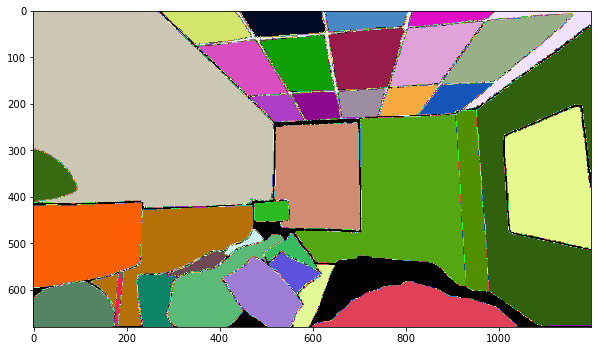

Current unique ids [-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17   18   19   20   21   22   23   24   25   26
   27   28   29   30   31   32   33   34   35   36   37   38   39]
The Found Projection instance 61
Mapping {-100: -100, 23: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 195, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 68: 0, 71: 0, 73: 0, 74: 56, 75: 0, 76: 0, 78: 2, 81: 0, 83: 0, 84: 0, 85: 0, 86: 0, 88: 0, 89: 0, 91: 0, 92: 0, 97: 0, 98: 0, 99: 0, 101: 0, 108: 0, 109: 0, 112: 0, 113: 0}
MaxId 114
The Found Projection instance 44
Mapping {-100: -100, 23: 1, 40: 0, 41: 0, 42: 0, 43: 0, 44: 292, 45: 0, 46: 0, 47: 0, 48: 3, 49: 0, 50: 0, 51: 3, 52: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 68: 0, 71: 0, 73: 0, 74: 0, 75: 0, 76: 0, 78: 0, 81: 0, 83: 0, 84: 0, 85: 0, 86: 0, 88: 0, 89: 0, 91: 0, 92: 0, 97: 0, 98: 0, 

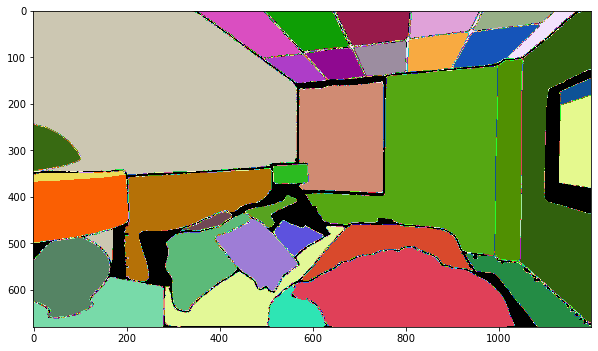

Current unique ids [-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17   18   19   20   21   22   23   24   25   26
   27   28   29   30   31   32   33   34   35   36   37   38   39   40
   41]
The Found Projection instance 61
Mapping {-100: -100, 23: 0, 40: 0, 42: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 54: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 229, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 68: 0, 71: 0, 73: 0, 74: 48, 75: 0, 76: 0, 78: 7, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 88: 0, 89: 0, 92: 0, 96: 0, 97: 0, 98: 0, 99: 0, 101: 0, 107: 0, 108: 0, 109: 0, 110: 0, 112: 0, 113: 0}
MaxId 114
The Found Projection instance 56
Mapping {-100: -100, 23: 0, 40: 0, 42: 0, 44: 0, 45: 0, 46: 0, 47: 8, 48: 0, 49: 0, 50: 5, 51: 0, 52: 8, 54: 4, 56: 49, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 68: 0, 71: 0, 73: 0, 74: 0, 75: 0, 76: 0, 78: 0, 81: 4, 82: 1, 83: 8, 84: 9, 85: 3, 86: 14, 88: 6, 89: 1, 9

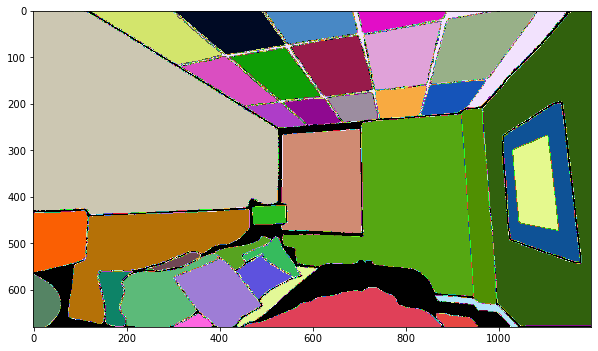

Current unique ids [-100    1    2    3    4    5    6    7    8    9   10   11   12   13
   14   15   16   17   18   19   20   21   22   23   24   25   26   27
   28   29   30   31   32   33   34   35   36   37   38   39   40   41
   42]
The Found Projection instance 23
Mapping {-100: -100, 23: 3, 40: 0, 44: 2, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 54: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 68: 0, 71: 0, 73: 0, 81: 0, 83: 0, 84: 0, 85: 0, 86: 0, 88: 0, 89: 0, 96: 0, 97: 0, 99: 1, 108: 0, 109: 0}
MaxId 115
The Found Projection instance 23
Mapping {-100: -100, 23: 114, 40: 0, 44: 2, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 54: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 68: 0, 71: 0, 73: 0, 81: 0, 83: 0, 84: 0, 85: 0, 86: 0, 88: 0, 89: 0, 96: 0, 97: 0, 99: 0, 108: 0, 109: 0}
MaxId 115
The Found Projection instance 86
Mapping {-100: -100, 23: 0, 40: 0, 44: 0, 45: 0, 46: 0, 47: 12

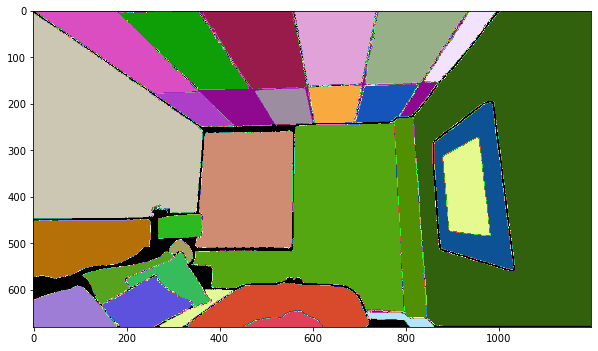

Current unique ids [-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17   18   19   20   21   22   23   24   25   26
   27   28   29   30]
The Found Projection instance 23
Mapping {-100: -100, 23: 79, 44: 8, 45: 0, 47: 0, 48: 2, 49: 0, 50: 0, 52: 0, 54: 0, 56: 0, 57: 1, 60: 0, 61: 0, 63: 1, 64: 0, 65: 0, 66: 1, 68: 0, 73: 0, 81: 0, 83: 0, 84: 0, 85: 0, 86: 0, 88: 0, 89: 0, 96: 0, 97: 0, 108: 0, 109: 0}
MaxId 115
The Found Projection instance 85
Mapping {-100: -100, 23: 0, 44: 0, 45: 0, 47: 13, 48: 0, 49: 0, 50: 9, 52: 5, 54: 4, 56: 32, 57: 0, 60: 0, 61: 0, 63: 0, 64: 0, 65: 0, 66: 0, 68: 0, 73: 0, 81: 2, 83: 4, 84: 0, 85: 174, 86: 16, 88: 10, 89: 8, 96: 0, 97: 0, 108: 0, 109: 100}
MaxId 115
The Found Projection instance 44
Mapping {-100: -100, 23: 0, 44: 357, 45: 0, 47: 0, 48: 3, 49: 0, 50: 0, 52: 0, 54: 0, 56: 0, 57: 0, 60: 0, 61: 0, 63: 0, 64: 0, 65: 0, 66: 0, 68: 0, 73: 0, 81: 0, 83: 0, 84: 0, 85: 0, 86: 0, 88: 0, 89: 0, 96: 0, 97: 0, 108:

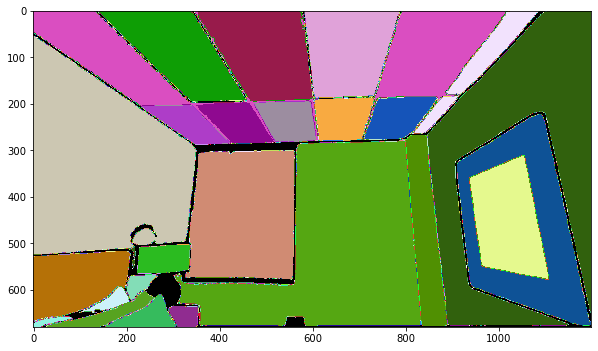

Current unique ids [-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17   18   19   20   21   22   23   24   25   26
   27]
The Found Projection instance 23
Mapping {-100: -100, 23: 179, 24: 0, 40: 0, 42: 0, 44: 2, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 63: 0, 64: 0, 65: 0, 66: 0, 68: 0, 73: 0, 81: 0, 85: 0, 86: 0, 88: 0, 89: 0, 96: 0, 97: 0, 98: 0, 99: 0}
MaxId 116
The Found Projection instance 44
Mapping {-100: -100, 23: 1, 24: 0, 40: 0, 42: 0, 44: 461, 45: 0, 46: 0, 47: 0, 48: 5, 49: 0, 50: 0, 51: 0, 52: 0, 56: 0, 57: 2, 58: 0, 59: 0, 60: 0, 61: 0, 63: 0, 64: 0, 65: 1, 66: 0, 68: 0, 73: 0, 81: 0, 85: 0, 86: 0, 88: 0, 89: 0, 96: 2, 97: 31, 98: 0, 99: 0}
MaxId 116
The Found Projection instance 57
Mapping {-100: -100, 23: 0, 24: 0, 40: 0, 42: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 56: 0, 57: 416, 58: 0, 59: 0, 60: 0, 61: 0, 63: 0, 64: 0, 65: 0, 66: 1, 68: 0,

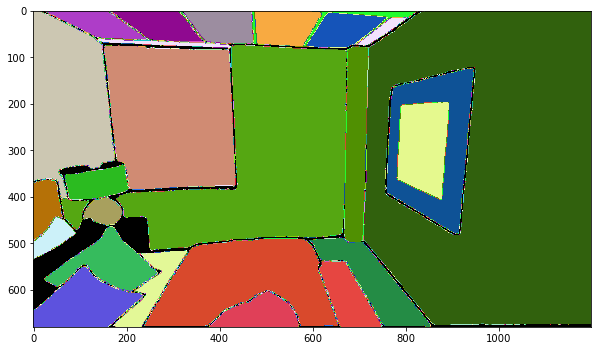

Current unique ids [-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17   18   19   20   21   22   23   24   25   26
   27]
The Found Projection instance 23
Mapping {-100: -100, 23: 112, 24: 0, 40: 0, 42: 0, 44: 6, 45: 0, 46: 0, 48: 3, 49: 0, 51: 1, 57: 0, 58: 0, 59: 0, 60: 0, 61: 1, 62: 0, 63: 1, 64: 0, 65: 0, 66: 0, 68: 0, 71: 0, 73: 0, 96: 0, 97: 0, 98: 0, 99: 4, 101: 0}
MaxId 116
The Found Projection instance 44
Mapping {-100: -100, 23: 1, 24: 0, 40: 0, 42: 0, 44: 410, 45: 0, 46: 0, 48: 1, 49: 0, 51: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 1, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 68: 0, 71: 0, 73: 0, 96: 3, 97: 0, 98: 0, 99: 0, 101: 0}
MaxId 116
The Found Projection instance 45
Mapping {-100: -100, 23: 0, 24: 0, 40: 0, 42: 0, 44: 0, 45: 162, 46: 0, 48: 0, 49: 34, 51: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 68: 0, 71: 0, 73: 0, 96: 0, 97: 0, 98: 0, 99: 0, 101: 0}
MaxId 116
The Found Projection instance 61
Mapping {

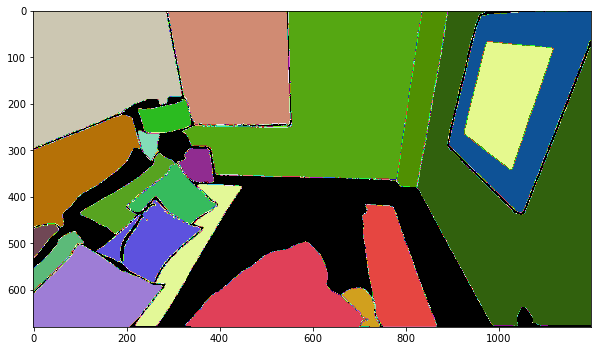

Current unique ids [-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17   18   20   21   22]
The Found Projection instance 44
Mapping {-100: -100, 23: 0, 40: 0, 42: 0, 44: 393, 46: 0, 48: 12, 51: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 3, 62: 0, 63: 2, 64: 0, 65: 0, 66: 0, 68: 0, 71: 0, 73: 0, 96: 3, 97: 33, 98: 0, 99: 2, 112: 0}
MaxId 116
The Found Projection instance 61
Mapping {-100: -100, 23: 0, 40: 0, 42: 0, 44: 0, 46: 0, 48: 0, 51: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 158, 62: 0, 63: 1, 64: 0, 65: 0, 66: 0, 68: 0, 71: 0, 73: 0, 96: 0, 97: 0, 98: 0, 99: 0, 112: 0}
MaxId 116
The Found Projection instance 46
Mapping {-100: -100, 23: 0, 40: 1, 42: 25, 44: 0, 46: 233, 48: 0, 51: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 68: 0, 71: 0, 73: 0, 96: 0, 97: 0, 98: 0, 99: 0, 112: 0}
MaxId 116
The Found Projection instance 63
Mapping {-100: -100, 23: 0, 40: 0, 42: 0, 44: 0, 46: 0, 48: 0, 51: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61:

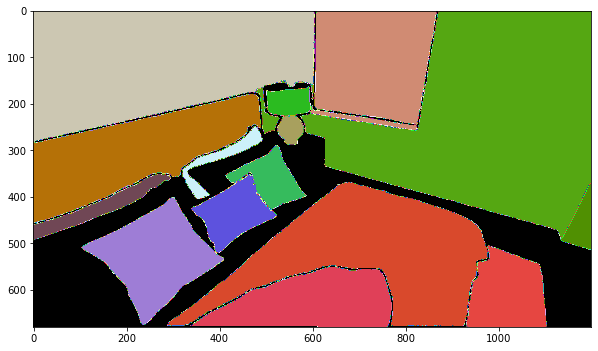

Current unique ids [-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17]
The Found Projection instance 44
Mapping {-100: -100, 23: 1, 44: 512, 45: 0, 46: 0, 48: 3, 49: 0, 51: 1, 57: 2, 58: 0, 59: 0, 60: 0, 61: 0, 63: 0, 64: 0, 65: 0, 66: 0, 68: 0, 73: 0, 96: 3, 97: 9, 98: 0, 99: 2}
MaxId 116
The Found Projection instance 61
Mapping {-100: -100, 23: 0, 44: 3, 45: 0, 46: 0, 48: 0, 49: 0, 51: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 121, 63: 4, 64: 0, 65: 0, 66: 0, 68: 0, 73: 0, 96: 0, 97: 24, 98: 0, 99: 0}
MaxId 116
The Found Projection instance 23
Mapping {-100: -100, 23: 85, 44: 1, 45: 0, 46: 0, 48: 1, 49: 0, 51: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 63: 0, 64: 0, 65: 0, 66: 0, 68: 0, 73: 0, 96: 0, 97: 0, 98: 0, 99: 0}
MaxId 116
The Found Projection instance 46
Mapping {-100: -100, 23: 0, 44: 0, 45: 0, 46: 186, 48: 0, 49: 0, 51: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 63: 0, 64: 0, 65: 0, 66: 0, 68: 0, 73: 0, 96: 0, 97: 0, 98: 0, 99: 0}
MaxId 116
The

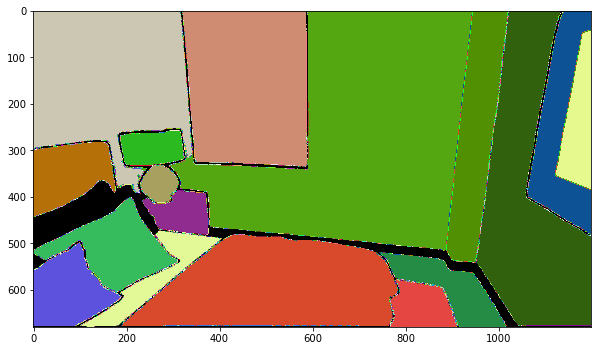

Current unique ids [-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17   18   19   20   21   22]
The Found Projection instance 23
Mapping {-100: -100, 23: 160, 44: 3, 45: 0, 47: 0, 48: 1, 49: 0, 50: 0, 52: 0, 54: 0, 56: 0, 85: 0, 86: 0, 88: 0, 108: 0, 109: 0}
MaxId 116
The Found Projection instance 56
Mapping {-100: -100, 23: 0, 44: 0, 45: 0, 47: 32, 48: 0, 49: 0, 50: 14, 52: 15, 54: 10, 56: 80, 85: 1, 86: 3, 88: 1, 108: 0, 109: 2}
MaxId 116
The Found Projection instance 44
Mapping {-100: -100, 23: 1, 44: 189, 45: 0, 47: 0, 48: 2, 49: 0, 50: 0, 52: 0, 54: 0, 56: 0, 85: 0, 86: 0, 88: 0, 108: 0, 109: 0}
MaxId 116
The Found Projection instance 49
Mapping {-100: -100, 23: 0, 44: 0, 45: 0, 47: 0, 48: 0, 49: 220, 50: 0, 52: 0, 54: 0, 56: 0, 85: 0, 86: 0, 88: 0, 108: 0, 109: 0}
MaxId 116
The Found Projection instance 52
Mapping {-100: -100, 23: 0, 44: 0, 45: 0, 47: 3, 48: 0, 49: 0, 50: 0, 52: 215, 54: 0, 56: 0, 85: 0, 86: 0, 88: 0, 108: 0, 109: 0}


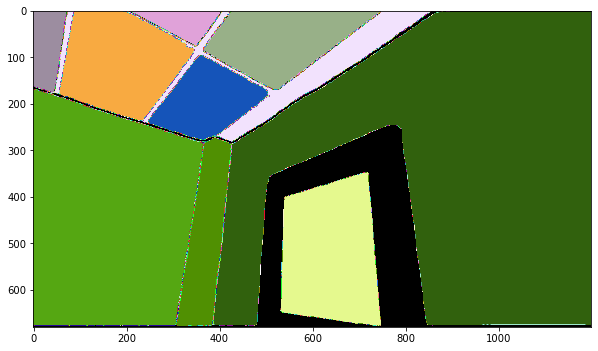

Current unique ids [-100    0    1    2    3    4    5    6    7    8    9   10   11]
The Found Projection instance 56
Mapping {-100: -100, 0: 0, 8: 0, 13: 0, 19: 34, 21: 9, 22: 0, 23: 0, 28: 0, 45: 0, 49: 0, 56: 68, 85: 5, 86: 1, 109: 44}
MaxId 116
The Found Projection instance 23
Mapping {-100: -100, 0: 0, 8: 0, 13: 0, 19: 0, 21: 0, 22: 0, 23: 89, 28: 0, 45: 0, 49: 0, 56: 0, 85: 0, 86: 0, 109: 0}
MaxId 116
The Found Projection instance 22
Mapping {-100: -100, 0: 0, 8: 0, 13: 0, 19: 0, 21: 0, 22: 33, 23: 0, 28: 0, 45: 0, 49: 0, 56: 0, 85: 0, 86: 0, 109: 0}
MaxId 116
The Found Projection instance 45
Mapping {-100: -100, 0: 0, 8: 0, 13: 0, 19: 0, 21: 0, 22: 0, 23: 0, 28: 0, 45: 63, 49: 9, 56: 0, 85: 0, 86: 0, 109: 0}
MaxId 116
The Found Projection instance 22
Mapping {-100: -100, 0: 0, 8: 0, 13: 0, 19: 0, 21: 0, 22: 20, 23: 0, 28: 0, 45: 0, 49: 0, 56: 0, 85: 0, 86: 0, 109: 0}
MaxId 116
CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT SEEEEEEEEEEEEEEEN
The Found Projection instance 0
Mappi

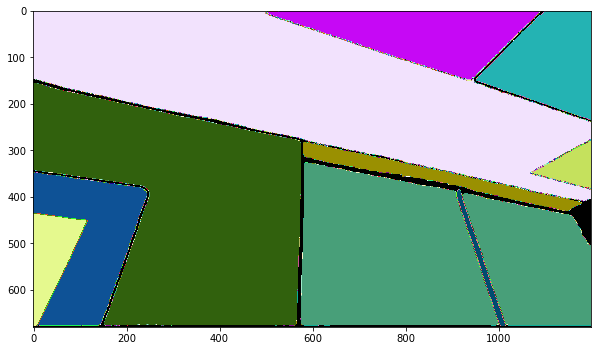

Current unique ids [-100    0    1    2    3    4    5    6    7    8    9   10   11]
The Found Projection instance 23
Mapping {-100: -100, 0: 0, 19: 0, 22: 0, 23: 238, 24: 0, 28: 0, 30: 0, 31: 0, 35: 2, 45: 0, 49: 0}
MaxId 117
The Found Projection instance 22
Mapping {-100: -100, 0: 0, 19: 0, 22: 126, 23: 0, 24: 0, 28: 0, 30: 0, 31: 0, 35: 0, 45: 0, 49: 0}
MaxId 117
The Found Projection instance 45
Mapping {-100: -100, 0: 0, 19: 0, 22: 0, 23: 0, 24: 0, 28: 0, 30: 0, 31: 0, 35: 0, 45: 109, 49: 6}
MaxId 117
The Found Projection instance 22
Mapping {-100: -100, 0: 0, 19: 0, 22: 66, 23: 0, 24: 0, 28: 0, 30: 0, 31: 0, 35: 0, 45: 0, 49: 0}
MaxId 117
The Found Projection instance 0
Mapping {-100: -100, 0: 11, 19: 0, 22: 0, 23: 0, 24: 0, 28: 0, 30: 0, 31: 0, 35: 0, 45: 0, 49: 0}
MaxId 117
The Found Projection instance 49
Mapping {-100: -100, 0: 0, 19: 0, 22: 0, 23: 0, 24: 0, 28: 0, 30: 0, 31: 0, 35: 0, 45: 0, 49: 5}
MaxId 117
The Found Projection instance 24
Mapping {-100: -100, 0: 0, 19: 0, 

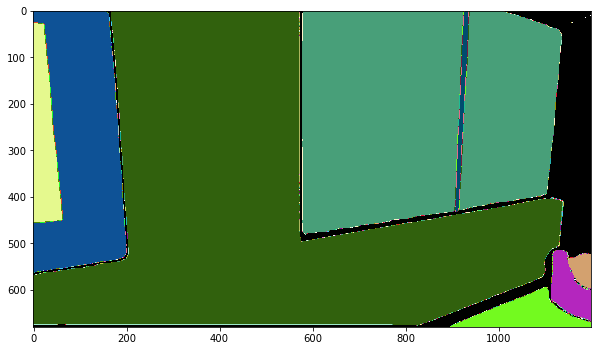

Current unique ids [-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14]
The Found Projection instance 0
Mapping {-100: -100, 0: 3, 1: 0, 5: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 2, 23: 0, 24: 0, 25: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 33: 0, 34: 0, 35: 1, 36: 0, 56: 0}
MaxId 117
The Found Projection instance 23
Mapping {-100: -100, 0: 0, 1: 0, 5: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 60, 24: 0, 25: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 33: 0, 34: 0, 35: 0, 36: 0, 56: 0}
MaxId 117
The Found Projection instance 22
Mapping {-100: -100, 0: 0, 1: 0, 5: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 151, 23: 0, 24: 0, 25: 0, 27: 0, 28: 82, 29: 0, 30: 0, 31: 0, 33: 0, 34: 0, 35: 0, 36: 0, 56: 0}
MaxId 117
The Found Projection instance 0
Mapping {-100: -100, 0: 111, 1: 0, 5: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 18: 0, 19:

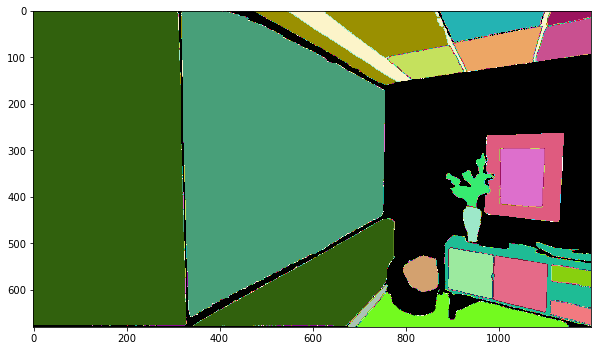

Current unique ids [-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17   18   19   20   21   22   23   24   25   26
   27]
The Found Projection instance 22
Mapping {-100: -100, 0: 0, 1: 0, 5: 0, 8: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 16: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 148, 23: 0, 24: 0, 25: 0, 27: 0, 28: 2, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 56: 0}
MaxId 117
The Found Projection instance 0
Mapping {-100: -100, 0: 196, 1: 0, 5: 0, 8: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 16: 0, 18: 0, 19: 0, 20: 1, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 56: 0}
MaxId 117
The Found Projection instance 24
Mapping {-100: -100, 0: 0, 1: 0, 5: 0, 8: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 16: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 71, 25: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 56: 0}
MaxId 117
The Found Projection instance 21
Mappin

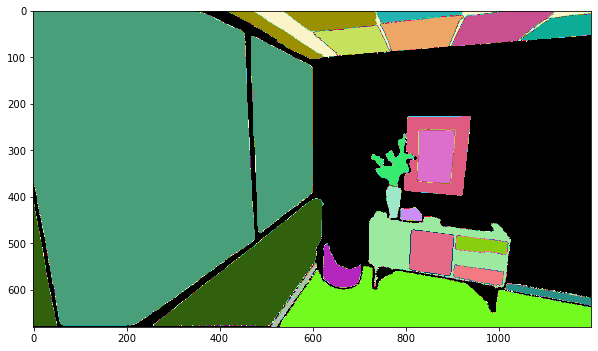

Current unique ids [-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17   18   19   20   21   22   23   24   25   26]
The Found Projection instance 22
Mapping {-100: -100, 0: 0, 5: 0, 8: 0, 10: 0, 12: 0, 14: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 201, 23: 0, 24: 0, 25: 0, 27: 0, 28: 3, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 56: 0}
MaxId 117
The Found Projection instance 0
Mapping {-100: -100, 0: 217, 5: 0, 8: 0, 10: 0, 12: 0, 14: 0, 18: 0, 19: 0, 20: 1, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 56: 0}
MaxId 117
The Found Projection instance 24
Mapping {-100: -100, 0: 0, 5: 0, 8: 0, 10: 0, 12: 0, 14: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 113, 25: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 56: 0}
MaxId 117
The Found Projection instance 22
Mapping {-100: -100, 0: 0, 5: 0, 8: 0, 10: 0, 12: 0, 14: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 

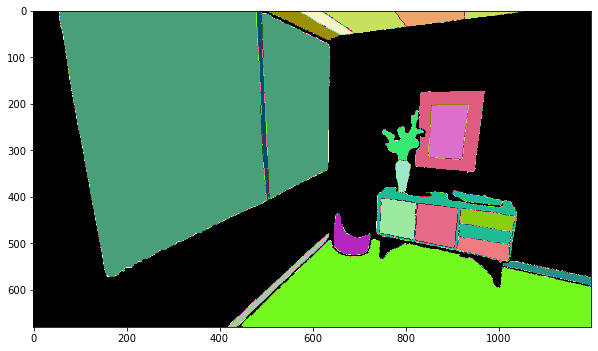

Current unique ids [-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17   18   19   20   21   22   23   24]
The Found Projection instance 22
Mapping {-100: -100, 0: 0, 5: 0, 12: 0, 14: 0, 18: 0, 20: 0, 22: 200, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 2, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0}
MaxId 117
The Found Projection instance 0
Mapping {-100: -100, 0: 262, 5: 0, 12: 0, 14: 0, 18: 0, 20: 1, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 1, 33: 0, 34: 0, 35: 0, 36: 0}
MaxId 117
The Found Projection instance 24
Mapping {-100: -100, 0: 0, 5: 0, 12: 0, 14: 0, 18: 0, 20: 0, 22: 0, 23: 0, 24: 162, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0}
MaxId 117
The Found Projection instance 22
Mapping {-100: -100, 0: 0, 5: 0, 12: 0, 14: 0, 18: 0, 20: 0, 22: 95, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 1, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0}
MaxId 117
The Fo

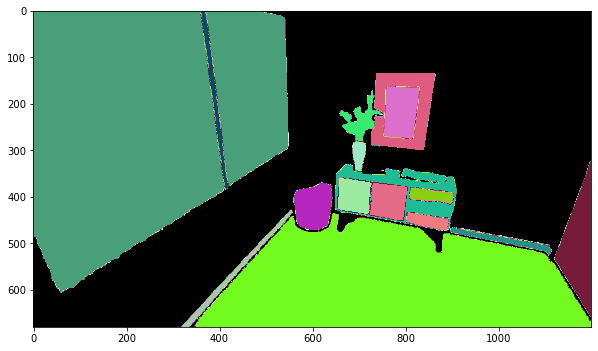

Current unique ids [-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17   18   19]
The Found Projection instance 0
Mapping {-100: -100, 0: 306, 2: 18, 3: 0, 4: 0, 5: 0, 12: 0, 14: 0, 18: 0, 19: 0, 20: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 1, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 61: 10, 74: 8, 75: 0, 76: 0, 91: 0, 92: 0, 94: 0, 113: 0}
MaxId 117
The Found Projection instance 22
Mapping {-100: -100, 0: 0, 2: 0, 3: 0, 4: 0, 5: 0, 12: 0, 14: 0, 18: 0, 19: 0, 20: 0, 22: 114, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 86, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 61: 0, 74: 0, 75: 0, 76: 0, 91: 0, 92: 0, 94: 0, 113: 0}
MaxId 117
The Found Projection instance 24
Mapping {-100: -100, 0: 0, 2: 0, 3: 0, 4: 0, 5: 0, 12: 0, 14: 0, 18: 0, 19: 0, 20: 0, 22: 0, 23: 0, 24: 175, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 61: 0, 74: 0, 75: 0, 76: 0, 91: 0, 92:

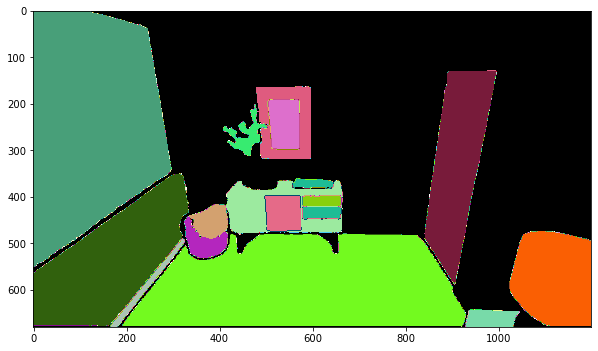

Current unique ids [-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17   18   19]
The Found Projection instance 0
Mapping {-100: -100, 0: 217, 2: 3, 3: 0, 4: 0, 5: 0, 12: 0, 14: 0, 18: 0, 20: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 29: 0, 30: 0, 31: 0, 32: 1, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 61: 12, 74: 1, 75: 0, 76: 0, 78: 0, 91: 0, 92: 0, 94: 0, 113: 0}
MaxId 117
The Found Projection instance 74
Mapping {-100: -100, 0: 2, 2: 9, 3: 0, 4: 0, 5: 0, 12: 0, 14: 0, 18: 0, 20: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 61: 29, 74: 39, 75: 0, 76: 0, 78: 9, 91: 0, 92: 0, 94: 0, 113: 0}
MaxId 117
The Found Projection instance 24
Mapping {-100: -100, 0: 0, 2: 0, 3: 0, 4: 0, 5: 0, 12: 0, 14: 0, 18: 0, 20: 0, 23: 0, 24: 160, 25: 0, 26: 0, 27: 0, 29: 0, 30: 1, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 61: 0, 74: 0, 75: 0, 76: 0, 78: 0, 91: 0, 92: 0, 94: 0, 113: 0}
MaxId 117
The Found Proje

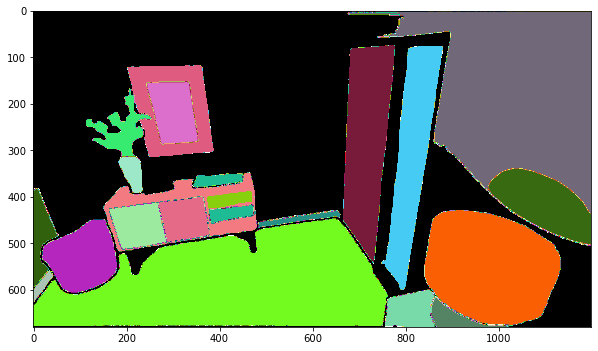

Current unique ids [-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17   18   19   20   21   22   23]
The Found Projection instance 61
Mapping {-100: -100, 0: 12, 1: 0, 2: 28, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 24: 0, 25: 0, 26: 0, 27: 0, 29: 0, 32: 0, 33: 0, 34: 0, 36: 0, 61: 132, 63: 0, 74: 126, 75: 0, 76: 0, 78: 5}
MaxId 117
The Found Projection instance 0
Mapping {-100: -100, 0: 209, 1: 0, 2: 0, 3: 0, 4: 0, 5: 4, 6: 0, 7: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 24: 0, 25: 0, 26: 0, 27: 0, 29: 0, 32: 0, 33: 0, 34: 0, 36: 0, 61: 0, 63: 0, 74: 0, 75: 0, 76: 0, 78: 0}
MaxId 117
The Found Projection instance 25
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 24: 0, 25: 106, 26: 0, 27: 6, 29: 20, 32

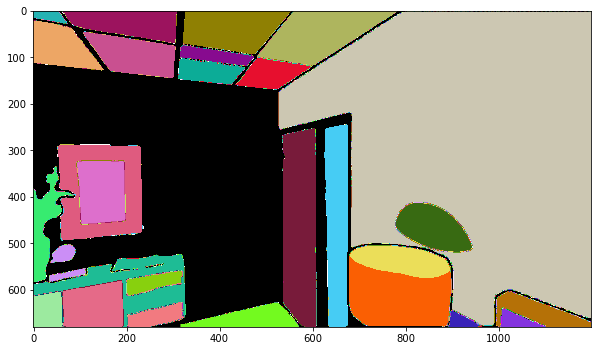

Current unique ids [-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17   18   19   20   21   22   23   24   25   26
   27   28   29   30]
The Found Projection instance 0
Mapping {-100: -100, 0: 241, 2: 0, 3: 0, 4: 0, 5: 0, 12: 0, 14: 1, 18: 0, 20: 1, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 29: 0, 30: 0, 31: 0, 32: 8, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 40: 0, 41: 0, 43: 0, 58: 0, 61: 0, 62: 0, 63: 0, 64: 0, 71: 0, 74: 0, 75: 0, 76: 0, 78: 0, 91: 0, 92: 0, 93: 0, 112: 0, 113: 0}
MaxId 119
The Found Projection instance 61
Mapping {-100: -100, 0: 7, 2: 6, 3: 0, 4: 0, 5: 0, 12: 0, 14: 0, 18: 0, 20: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 40: 0, 41: 0, 43: 0, 58: 0, 61: 111, 62: 0, 63: 0, 64: 0, 71: 0, 74: 93, 75: 0, 76: 0, 78: 8, 91: 0, 92: 0, 93: 0, 112: 0, 113: 0}
MaxId 119
The Found Projection instance 24
Mapping {-100: -100, 0: 0, 2: 0, 3: 0, 4: 0, 5: 0, 12: 0, 14: 0, 18: 0, 20: 0, 23: 0

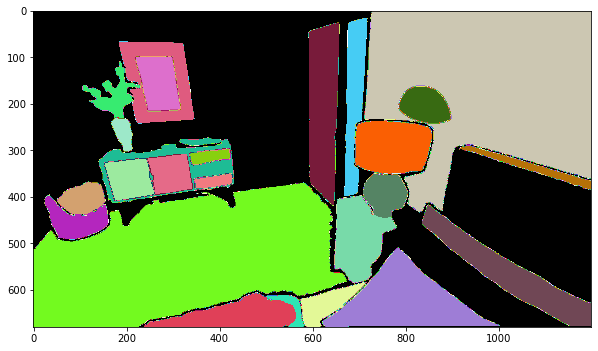

Current unique ids [-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17   18   19   20   21   22   23   24   25   26
   27   28]
The Found Projection instance 40
Mapping {-100: -100, 0: 0, 4: 0, 23: 0, 24: 0, 25: 0, 26: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 40: 311, 41: 8, 42: 0, 43: 11, 46: 0, 58: 0, 59: 0, 62: 0, 64: 0, 91: 0, 92: 0, 93: 0, 101: 35}
MaxId 119
The Found Projection instance 32
Mapping {-100: -100, 0: 3, 4: 0, 23: 1, 24: 0, 25: 1, 26: 0, 29: 0, 30: 0, 31: 0, 32: 105, 33: 0, 34: 0, 35: 90, 40: 0, 41: 0, 42: 0, 43: 0, 46: 0, 58: 0, 59: 0, 62: 0, 64: 0, 91: 0, 92: 0, 93: 0, 101: 0}
MaxId 119
The Found Projection instance 23
Mapping {-100: -100, 0: 0, 4: 0, 23: 97, 24: 0, 25: 0, 26: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 7, 40: 0, 41: 0, 42: 0, 43: 0, 46: 0, 58: 0, 59: 0, 62: 0, 64: 0, 91: 0, 92: 0, 93: 0, 101: 0}
MaxId 119
The Found Projection instance 62
Mapping {-100: -100, 0: 0, 4: 0, 23: 0, 24: 0, 25: 

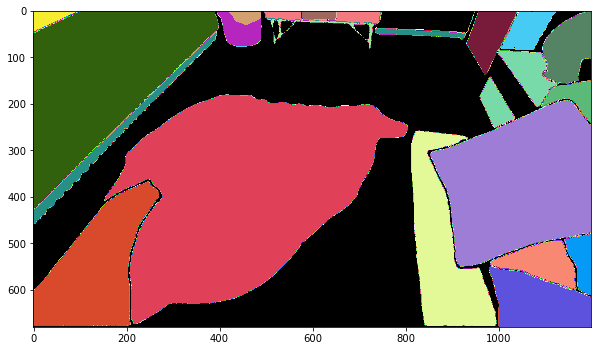

Current unique ids [-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17   18   19   20   21   22   23]
The Found Projection instance 46
Mapping {-100: -100, 23: 0, 24: 0, 32: 0, 35: 0, 39: 0, 40: 4, 42: 19, 44: 0, 46: 165, 51: 0, 98: 0, 101: 0}
MaxId 123
The Found Projection instance 40
Mapping {-100: -100, 23: 0, 24: 0, 32: 0, 35: 0, 39: 0, 40: 282, 42: 0, 44: 0, 46: 0, 51: 0, 98: 0, 101: 35}
MaxId 123
The Found Projection instance 24
Mapping {-100: -100, 23: 0, 24: 82, 32: 0, 35: 0, 39: 0, 40: 1, 42: 0, 44: 0, 46: 0, 51: 56, 98: 0, 101: 0}
MaxId 123


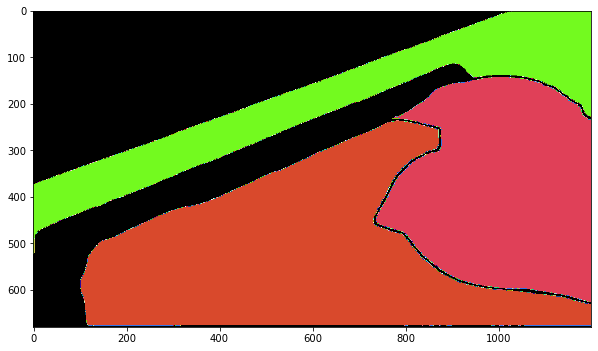

Current unique ids [-100    0    1    2]
The Found Projection instance 23
Mapping {-100: -100, 23: 186, 24: 0, 32: 0, 39: 0, 40: 0, 44: 5, 45: 1, 46: 0, 48: 137, 49: 0, 51: 1, 98: 0, 99: 0}
MaxId 123
The Found Projection instance 44
Mapping {-100: -100, 23: 0, 24: 0, 32: 0, 39: 0, 40: 0, 44: 88, 45: 0, 46: 0, 48: 1, 49: 0, 51: 0, 98: 0, 99: 1}
MaxId 123
The Found Projection instance 98
Mapping {-100: -100, 23: 0, 24: 0, 32: 0, 39: 24, 40: 0, 44: 0, 45: 0, 46: 0, 48: 0, 49: 0, 51: 0, 98: 146, 99: 0}
MaxId 123
The Found Projection instance 45
Mapping {-100: -100, 23: 0, 24: 0, 32: 0, 39: 0, 40: 0, 44: 0, 45: 92, 46: 0, 48: 0, 49: 12, 51: 0, 98: 0, 99: 0}
MaxId 123
The Found Projection instance 46
Mapping {-100: -100, 23: 0, 24: 0, 32: 0, 39: 0, 40: 0, 44: 0, 45: 0, 46: 44, 48: 0, 49: 0, 51: 0, 98: 0, 99: 0}
MaxId 123
The Found Projection instance 49
Mapping {-100: -100, 23: 0, 24: 0, 32: 0, 39: 0, 40: 0, 44: 0, 45: 0, 46: 0, 48: 0, 49: 59, 51: 0, 98: 0, 99: 0}
MaxId 123
The Found Project

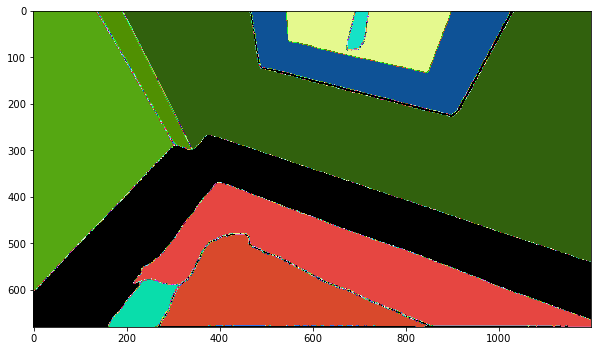

Current unique ids [-100    0    1    2    3    4    5    6    7    8    9   10   11   12]
The Found Projection instance 23
Mapping {-100: -100, 23: 204, 24: 0, 44: 6, 45: 5, 46: 0, 48: 4, 49: 0, 51: 4, 98: 0, 99: 16, 124: 0}
MaxId 125
The Found Projection instance 44
Mapping {-100: -100, 23: 1, 24: 0, 44: 355, 45: 0, 46: 0, 48: 2, 49: 0, 51: 0, 98: 0, 99: 0, 124: 0}
MaxId 125
The Found Projection instance 49
Mapping {-100: -100, 23: 0, 24: 0, 44: 0, 45: 227, 46: 0, 48: 0, 49: 317, 51: 0, 98: 0, 99: 0, 124: 2}
MaxId 125
The Found Projection instance 51
Mapping {-100: -100, 23: 0, 24: 12, 44: 0, 45: 0, 46: 0, 48: 0, 49: 0, 51: 87, 98: 0, 99: 0, 124: 0}
MaxId 125
The Found Projection instance 98
Mapping {-100: -100, 23: 0, 24: 0, 44: 0, 45: 0, 46: 0, 48: 0, 49: 0, 51: 0, 98: 122, 99: 0, 124: 0}
MaxId 125
The Found Projection instance 48
Mapping {-100: -100, 23: 3, 24: 0, 44: 2, 45: 0, 46: 0, 48: 327, 49: 0, 51: 0, 98: 0, 99: 1, 124: 0}
MaxId 125
The Found Projection instance 45
Mapping {

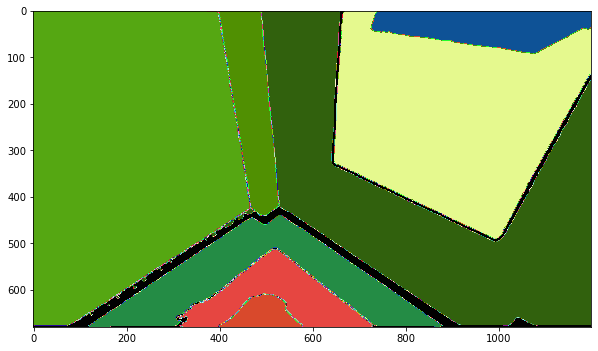

Current unique ids [-100    0    1    2    3    4    5    6    7    8    9   10]


In [9]:
# main loop
samples=None
visu=vis.visualizerForIds()
max_id=0
howManyFrames=40
for i in range(0,howManyFrames):
    currFramenumber=i*2000//howManyFrames
    color_data = cv2.imread(color_paths[currFramenumber])
    image = cv2.cvtColor(color_data, cv2.COLOR_BGR2RGB)
    masks, samples, max_id=createFrontMappingAutosort(currFramenumber, T_wc, K, depth_paths, mask_generator, max_id=max_id, smallesMaskSize=1000,current_frame=image, samples=samples,verbose=False)
    #print(i)
torch.cuda.empty_cache()